In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

In [3]:
!pip install -q mlflow
!pip install -q python-dotenv

In [4]:
import os
project_folder = '/content/drive/MyDrive/nba-project'
os.chdir(project_folder)
pickles_folder = os.path.join(os.getcwd(), 'datasets')
os.getcwd()

'/content/drive/MyDrive/nba-project'

In [5]:
import custom_modules.modelling_lib_rodrixx as mod
import custom_modules.preprocessing_lib_rodrixx as prep

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import os

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

from dotenv import load_dotenv

from mlflow.server import get_app_client
import mlflow

In [6]:
env_path = os.path.join(os.getcwd(), 'env_files', '.env')
load_dotenv(env_path)
dataframes_path = os.path.join(os.getcwd(), 'datasets')
csv_path = os.path.join(os.getcwd(), 'column_csv')

In [7]:
df = pd.read_pickle(os.path.join(dataframes_path, 'stats_1982_to_2024.pkl'))

In [8]:
df.head()

,Player,Pos,Age,Tm,G,GS,MP_pg,FG_pg,FGA_pg,FG%,...,DBPM_rank,BPM_rank,VORP_rank,%W,GT,%W_rank,%G,Votes,Share,MaxVotes
0,Kareem Abdul-Jabbar,C,34,LAL,76,76,35.2,9.9,17.1,0.579,...,20,5,8,0.695,82,3,0.927,31,0.045,690
1,Alvan Adams,C,27,PHO,79,75,30.3,6.4,13.0,0.494,...,10,13,15,0.561,82,10,0.963,0,0.000,690
2,Mark Aguirre,SF,22,DAL,51,20,28.8,7.5,16.1,0.465,...,48,34,36,0.341,82,36,0.622,0,0.000,690
3,Danny Ainge,SG,22,BOS,53,1,10.6,1.5,4.2,0.357,...,22,68,47,0.768,82,1,0.646,0,0.000,690
4,Tiny Archibald,PG,33,BOS,68,51,31.9,4.5,9.6,0.472,...,45,40,35,0.768,82,1,0.829,0,0.000,690


In [9]:
cols_tot = [col for col in df.columns if '_tot' in col]
cols_to_drop = ['G', 'GS', 'GT', 'Votes', 'MaxVotes', 'Tm']
cols_to_drop += cols_tot
cols_to_filter = ['PER', 'WS/48', 'BPM', 'USG%']
col_to_ohe = 'Pos'

In [10]:
pipe_clean = Pipeline(steps = [
    ('DropPlayersMultiTeams', prep.DropPlayersMultiTeams()),
    ('OutlierFilter', prep.OutlierFilter(q = .0005, col_to_filter = cols_to_filter)),
    ('SetIndex', prep.SetIndex()),
    ('OHE', prep.OHE(col_to_ohe)),
    ('DropColumns', prep.DropColumns(cols_to_drop)),
    ('DropPlayers', prep.DropPlayers()),
])

In [11]:
df = pipe_clean.fit_transform(df)

In [12]:
df.head()

,,Age,MP_pg,FG_pg,FGA_pg,FG%,3P_pg,3PA_pg,3P%,2P_pg,2PA_pg,...,VORP_rank,%W,%W_rank,%G,Share,Pos_C,Pos_PF,Pos_PG,Pos_SF,Pos_SG
Player,Season,,,,,,,,,,,,,,,,,,,,,
Kareem Abdul-Jabbar,1982,34,35.2,9.9,17.1,0.579,0.0,0.0,0.000,9.9,17.1,...,8,0.695,3,0.927,0.045,1,0,0,0,0
Alvan Adams,1982,27,30.3,6.4,13.0,0.494,0.0,0.0,0.000,6.4,13.0,...,15,0.561,10,0.963,0.000,1,0,0,0,0
Mark Aguirre,1982,22,28.8,7.5,16.1,0.465,0.5,1.4,0.352,7.0,14.7,...,36,0.341,36,0.622,0.000,0,0,0,1,0
Danny Ainge,1982,22,10.6,1.5,4.2,0.357,0.1,0.3,0.294,1.4,3.8,...,47,0.768,1,0.646,0.000,0,0,0,0,1
Tiny Archibald,1982,33,31.9,4.5,9.6,0.472,0.1,0.2,0.375,4.4,9.4,...,35,0.768,1,0.829,0.000,0,0,1,0,0


In [13]:
len(df[df.index.get_level_values(1) > 2016]) / len(df)

0.23062553373185313

In [14]:
val_df = df[df.index.get_level_values(1) > 2016]
dev_df = df[df.index.get_level_values(1) <= 2016]

In [15]:
dev_df, sampling_ratio = mod.oversample(dev_df, os_param = 'ros', sampling_strategy = .4)

In [16]:
X_train = dev_df.drop('Share', axis=1)
y_train = dev_df[['Share']]

X_val = val_df.drop('Share', axis=1)
y_val = val_df[['Share']]

In [17]:
scaler = MinMaxScaler()
scaler.fit(pd.concat([X_train, X_val], ignore_index = True))

MinMaxScaler()

In [18]:
datasets = {'train': X_train, 'val': X_val}
real_targets = {'train': y_train, 'val': y_val}

In [19]:
datasets['val']

,,Age,MP_pg,FG_pg,FGA_pg,FG%,3P_pg,3PA_pg,3P%,2P_pg,2PA_pg,...,BPM_rank,VORP_rank,%W,%W_rank,%G,Pos_C,Pos_PF,Pos_PG,Pos_SF,Pos_SG
Player,Season,,,,,,,,,,,,,,,,,,,,,
Álex Abrines,2017,23,15.5,2.0,5.0,0.393,1.4,3.6,0.381,0.6,1.4,...,78,49,0.573,9,0.829,0,0,0,0,1
Quincy Acy,2017,26,14.7,1.8,4.5,0.412,1.0,2.4,0.411,0.9,2.1,...,83,50,0.269,64,0.463,0,1,0,0,0
Steven Adams,2017,23,29.9,4.7,8.2,0.571,0.0,0.0,0.000,4.7,8.2,...,64,39,0.573,9,0.976,1,0,0,0,0
Arron Afflalo,2017,31,25.9,3.0,6.9,0.440,1.0,2.5,0.411,2.0,4.4,...,98,57,0.390,51,0.744,0,0,0,0,1
Alexis Ajinça,2017,28,15.0,2.3,4.6,0.500,0.0,0.1,0.000,2.3,4.5,...,95,52,0.415,41,0.476,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Jalen Crutcher,2024,24,3.0,0.0,1.0,0.000,0.0,0.0,0.000,0.0,1.0,...,183,52,0.598,9,0.012,0,0,1,0,0
Andrew Funk,2024,24,2.6,0.0,0.8,0.000,0.0,0.6,0.000,0.0,0.2,...,169,52,0.476,33,0.061,0,0,0,0,1
Kaiser Gates,2024,27,7.0,0.0,4.0,0.000,0.0,2.0,0.000,0.0,2.0,...,184,53,0.598,9,0.012,0,0,0,1,0


In [20]:
# for key, dataset in datasets.items():
#     index_param = dataset.index
#     pipe_scale.set_params(**{'ArrayToDf__index': index_param})
#     datasets[key] = pipe_scale.transform(dataset)

In [21]:
mlflow.set_experiment('Random Forest')

<Experiment: artifact_location='gs://nba-mvp-prediction-mlflow-artifacts/3', creation_time=1699641677571, experiment_id='3', last_update_time=1699641677571, lifecycle_stage='active', name='Random Forest', tags={}>

In [22]:
param_grid = {
    'max_depth': [8],
    'min_samples_split': [10],
    'max_features': [.5],
    'n_estimators': [230]
    }

In [23]:
with mlflow.start_run():
    estimator = RandomForestRegressor(random_state = 23)

    model = GridSearchCV(estimator, param_grid, scoring = ('neg_root_mean_squared_error', 'r2'), refit = 'neg_root_mean_squared_error', cv = 10, verbose = 2)

    model.fit(X_train, y_train)

    results = model.cv_results_

    cv_scores = mod.get_cv_scores(results)

    best_model, best_params, best_cv_score = mod.retrieve_best(model)

    predicted_targets = mod.predict_model(best_model, datasets)

    mod.log_sampling_ratio_mlflow(sampling_ratio)

    mod.log_params_mlflow_rf(best_params)

    mod.log_metrics_mlflow(real_targets, predicted_targets, cv_scores)

    mod.log_advanced_metrics_mlflow(real_targets['val'], predicted_targets['val'])

    mod.log_model_mlflow(best_model)

    mod.log_features_mlflow(X_train, csv_path)

    mod.log_important_features_mlflow(mod.display_feature_importances(best_model))

    mod.log_val_results_mlflow(*mod.display_val_results_graphs(real_targets['val'], predicted_targets['val']))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=230; total time= 1.0min
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=230; total time=  54.0s
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=230; total time=  53.1s
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=230; total time=  53.2s
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=230; total time=  52.8s
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=230; total time=  57.1s
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=230; total time=  53.4s
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=230; total time=  54.5s
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=230; total time=  53.2s
[CV] END max_depth=8, max_features=0.5, min_samp

2024/11/01 14:22:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/01 14:22:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run skillful-squid-816 at: https://nba-mvp-prediction.xyz/mlflow/#/experiments/3/runs/97bdae7203b941ad9a864993a8f5eb00.
2024/11/01 14:22:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://nba-mvp-prediction.xyz/mlflow/#/experiments/3.


In [ ]:
mod.display_metrics(real_targets, predicted_targets, cv_scores)

,Train,CV,Validation
RMSE,0.015107,0.015780,0.031600
R2,0.990639,0.977323,0.679969


In [24]:
contenders_df, no_contenders_df = mod.get_val_results(real_targets['val'], predicted_targets['val'])

In [25]:
mod.display_val_results(contenders_df, no_contenders_df)

Contenders Results:


,,Share,PredShare
Player,Season,,
Russell Westbrook,2017,0.879,0.357724
James Harden,2017,0.746,0.519885
Kawhi Leonard,2017,0.495,0.490340
LeBron James,2017,0.330,0.273776
Isaiah Thomas,2017,0.080,0.184257
Stephen Curry,2017,0.051,0.248279
Giannis Antetokounmpo,2017,0.007,0.097514
John Wall,2017,0.007,0.062424
Anthony Davis,2017,0.002,0.137173


,,Share,PredShare
Player,Season,,
James Harden,2018,0.955,0.706708
LeBron James,2018,0.731,0.370913
Anthony Davis,2018,0.441,0.190088
Damian Lillard,2018,0.205,0.143808
Russell Westbrook,2018,0.075,0.183941
Giannis Antetokounmpo,2018,0.074,0.123515
Kevin Durant,2018,0.065,0.222851
DeMar DeRozan,2018,0.032,0.013702
LaMarcus Aldridge,2018,0.006,0.052262


,,Share,PredShare
Player,Season,,
Giannis Antetokounmpo,2019,0.932,0.593570
James Harden,2019,0.768,0.544840
Paul George,2019,0.352,0.105961
Nikola Jokić,2019,0.210,0.108438
Stephen Curry,2019,0.173,0.171915
Damian Lillard,2019,0.068,0.149451
Joel Embiid,2019,0.049,0.085812
Kevin Durant,2019,0.025,0.196337
Kawhi Leonard,2019,0.013,0.204731


,,Share,PredShare
Player,Season,,
Giannis Antetokounmpo,2020,0.952,0.600013
LeBron James,2020,0.746,0.394236
James Harden,2020,0.363,0.409878
Luka Dončić,2020,0.198,0.147909
Kawhi Leonard,2020,0.166,0.172819
Anthony Davis,2020,0.081,0.330826
Chris Paul,2020,0.026,0.013039
Damian Lillard,2020,0.023,0.169631
Nikola Jokić,2020,0.018,0.032579


,,Share,PredShare
Player,Season,,
Nikola Jokić,2021,0.961,0.486813
Joel Embiid,2021,0.580,0.159385
Stephen Curry,2021,0.449,0.190711
Giannis Antetokounmpo,2021,0.345,0.299701
Chris Paul,2021,0.138,0.033923
Luka Dončić,2021,0.042,0.155071
Damian Lillard,2021,0.038,0.169521
Julius Randle,2021,0.020,0.025358
Derrick Rose,2021,0.010,0.000236


,,Share,PredShare
Player,Season,,
Nikola Jokić,2022,0.875,0.442548
Joel Embiid,2022,0.706,0.286665
Giannis Antetokounmpo,2022,0.595,0.293439
Devin Booker,2022,0.216,0.065228
Luka Dončić,2022,0.146,0.199839
Jayson Tatum,2022,0.043,0.077573
Ja Morant,2022,0.010,0.186724
Stephen Curry,2022,0.004,0.069667
Chris Paul,2022,0.002,0.069901


,,Share,PredShare
Player,Season,,
Joel Embiid,2023,0.915,0.391321
Nikola Jokić,2023,0.674,0.425762
Giannis Antetokounmpo,2023,0.606,0.341230
Jayson Tatum,2023,0.280,0.248543
Shai Gilgeous-Alexander,2023,0.046,0.228319
Donovan Mitchell,2023,0.030,0.093846
Domantas Sabonis,2023,0.027,0.141290
Luka Dončić,2023,0.010,0.215561
Stephen Curry,2023,0.005,0.069817


,,Share,PredShare
Player,Season,,
Shai Gilgeous-Alexander,2024,0.646,0.492314
Giannis Antetokounmpo,2024,0.194,0.306084
Jalen Brunson,2024,0.143,0.128949
Jayson Tatum,2024,0.087,0.128875
Anthony Edwards,2024,0.018,0.033481
Domantas Sabonis,2024,0.003,0.153782
Kevin Durant,2024,0.001,0.059354


No contenders results:


,,Share,PredShare
Player,Season,,
Álex Abrines,2017,0.0,0.000233
Quincy Acy,2017,0.0,0.000233
Steven Adams,2017,0.0,0.000264
Arron Afflalo,2017,0.0,0.000233
Alexis Ajinça,2017,0.0,0.000233
...,...,...,...
Jalen Crutcher,2024,0.0,0.000233
Andrew Funk,2024,0.0,0.000233
Kaiser Gates,2024,0.0,0.000233


In [26]:
no_contenders_df[no_contenders_df['PredShare'] > 0.1]

,,Share,PredShare
Player,Season,,
Jimmy Butler,2017,0.0,0.146781
DeMarcus Cousins,2017,0.0,0.101329
Rudy Gobert,2017,0.0,0.206980
Karl-Anthony Towns,2017,0.0,0.111909
Chris Paul,2018,0.0,0.104948
Anthony Davis,2019,0.0,0.110204
Trevon Duval,2019,0.0,0.126941
Bradley Beal,2020,0.0,0.119174
Rudy Gobert,2020,0.0,0.128729


<Axes: title={'center': 'Most important features'}, xlabel='Feature', ylabel='Importance coefficient'>

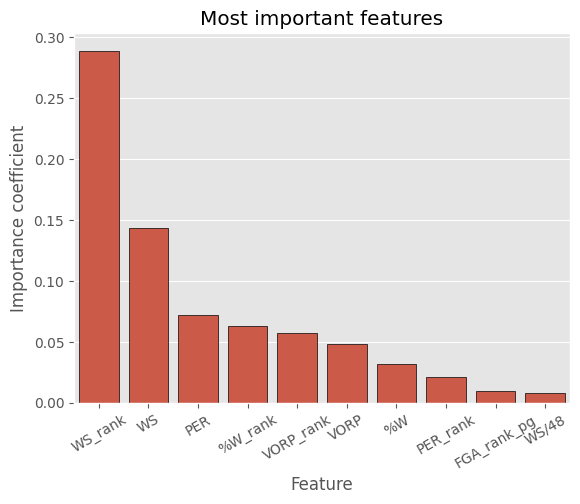

In [27]:
mod.display_feature_importances(best_model)

In [28]:
cont_df, no_cont_df = mod.get_val_results(real_targets['val'], predicted_targets['val'])

(<Figure size 4000x4000 with 8 Axes>, <Figure size 4000x4000 with 8 Axes>)

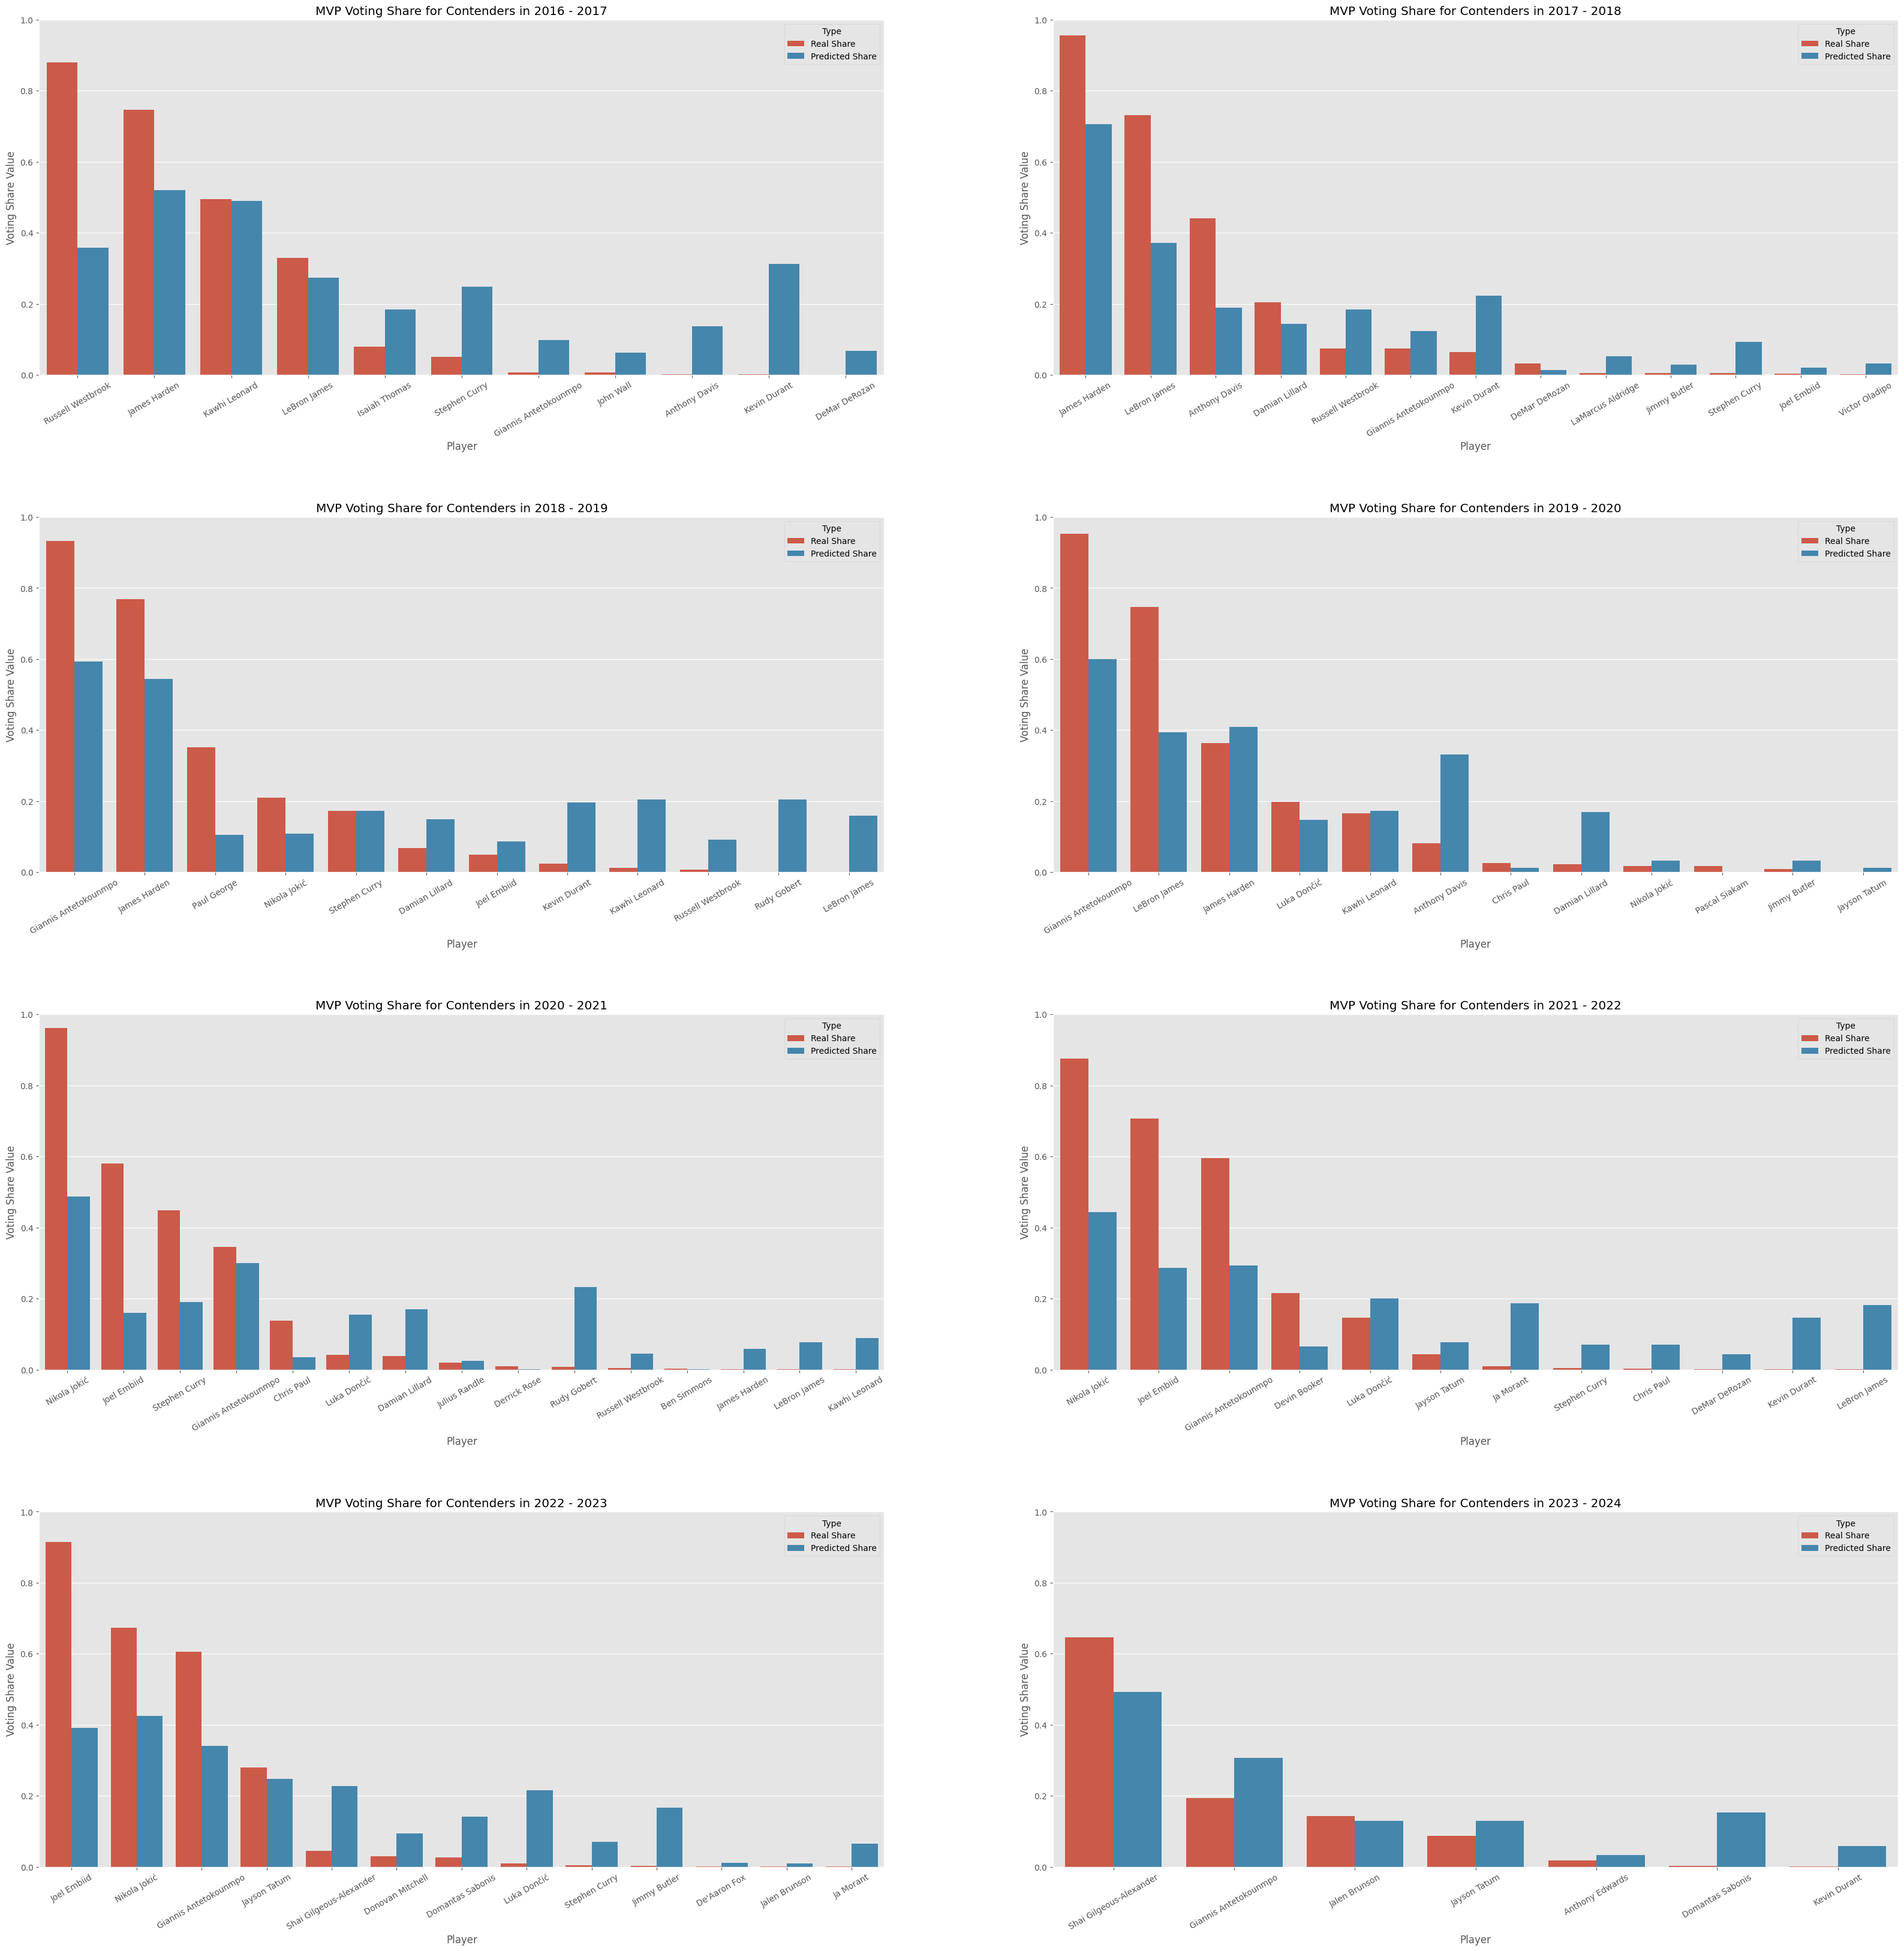

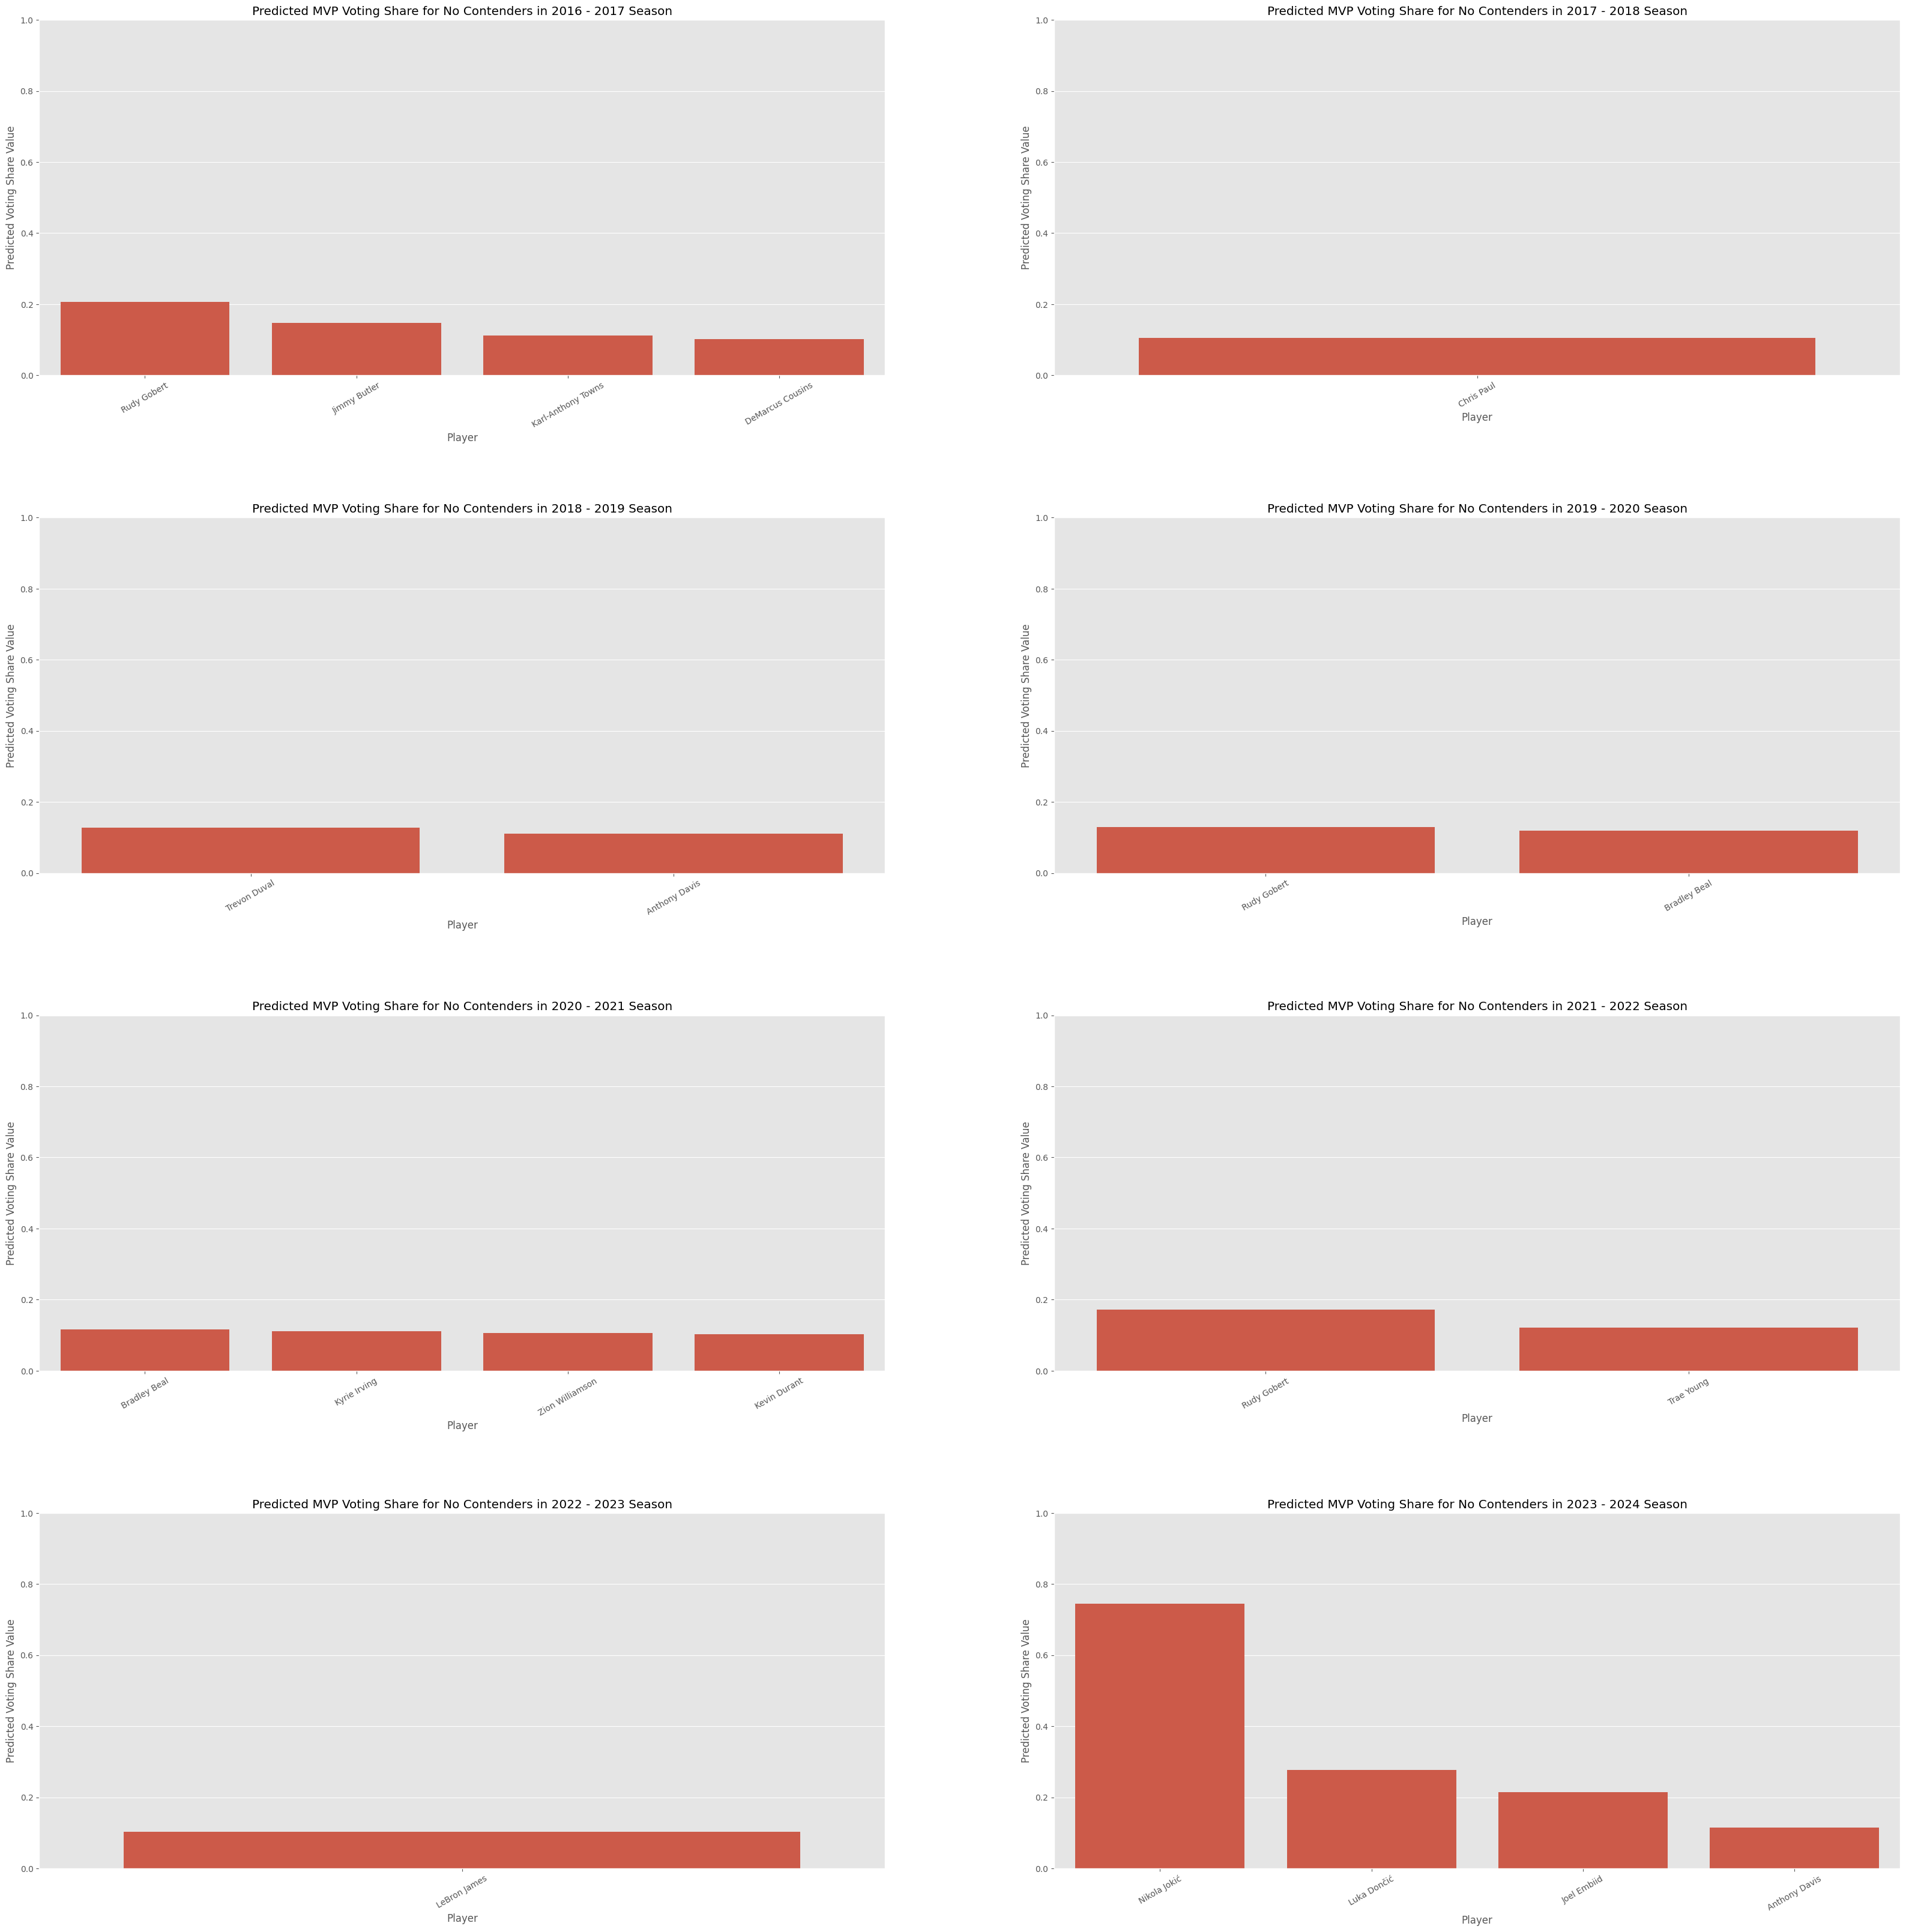

In [29]:
mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'])